### HW 3

#### Goal


```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
```


In [368]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [369]:
df = pd.read_csv('./data/course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [370]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [371]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [372]:
df = df.fillna({col: 0.0 for col in df.select_dtypes(include=['int64', 'float64']).columns})
df = df.fillna({col: 'NA' for col in df.select_dtypes(include=['object']).columns})

Q1 : What is the most frequent observation (mode) for the column industry?

In [373]:
df['industry'].mode()

0    retail
Name: industry, dtype: object

### Correlation matrix

use .corr()

In [374]:
corr_matrix = df.select_dtypes(include=['number']).drop(columns=['converted']).corr()
print(corr_matrix)


                          number_of_courses_viewed  annual_income  \
number_of_courses_viewed                  1.000000       0.009770   
annual_income                             0.009770       1.000000   
interaction_count                        -0.023565       0.027036   
lead_score                               -0.004879       0.015610   

                          interaction_count  lead_score  
number_of_courses_viewed          -0.023565   -0.004879  
annual_income                      0.027036    0.015610  
interaction_count                  1.000000    0.009888  
lead_score                         0.009888    1.000000  


In [375]:
from sklearn.model_selection import train_test_split

df_full , df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [376]:
y_train = df_train.converted
y_val = df_val.converted
y_test = df_test.converted

In [377]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [378]:
df_train.shape, df_val.shape, df_test.shape

((876, 8), (293, 8), (293, 8))

### Mutual Information

In [379]:
from sklearn.metrics import mutual_info_score

categorical_vars = df_train.select_dtypes(include=['object']).columns.tolist()
numerical_vars = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()


# Exclude 'churn' and 'customerid' from categorical columns
valid_cols = [col for col in categorical_vars]

# Compute mutual information for each categorical column
mi_scores = df_train[valid_cols].apply(
    lambda x: round(mutual_info_score(x, y_train),2)
)

# Sort descending
mi_scores = mi_scores.sort_values(ascending=False)
print(mi_scores)



lead_source          0.04
industry             0.01
employment_status    0.01
location             0.00
dtype: float64


### Logistic regression

##### One Hot Encoding

In [380]:
from sklearn.feature_extraction import DictVectorizer

# prepare data
train_dicts = df_train[categorical_vars + numerical_vars].to_dict(orient='records')
val_dicts   = df_val[categorical_vars + numerical_vars].to_dict(orient='records')
test_dicts  = df_test[categorical_vars + numerical_vars].to_dict(orient='records')

# fit + transform on train
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

# transform only on val/test
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)


In [381]:
dv.get_feature_names_out()

array(['annual_income', 'employment_status=NA',
       'employment_status=employed', 'employment_status=self_employed',
       'employment_status=student', 'employment_status=unemployed',
       'industry=NA', 'industry=education', 'industry=finance',
       'industry=healthcare', 'industry=manufacturing', 'industry=other',
       'industry=retail', 'industry=technology', 'interaction_count',
       'lead_score', 'lead_source=NA', 'lead_source=events',
       'lead_source=organic_search', 'lead_source=paid_ads',
       'lead_source=referral', 'lead_source=social_media', 'location=NA',
       'location=africa', 'location=asia', 'location=australia',
       'location=europe', 'location=middle_east',
       'location=north_america', 'location=south_america',
       'number_of_courses_viewed'], dtype=object)

In [382]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

print(X_train.shape)
model.fit(X_train, y_train)  # fitting the model

(876, 31)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [383]:
model.intercept_[0]

np.float64(-0.06914728027832062)

In [384]:
model.coef_[0]

array([-1.77843869e-05, -1.47154423e-02,  3.39095225e-02,  2.66248432e-03,
        1.15238518e-02, -1.02527697e-01, -2.48510995e-02,  4.93604222e-02,
       -2.01258344e-02, -1.34214865e-02, -3.00232200e-03, -9.25991830e-03,
       -3.17957304e-02, -1.60513114e-02,  3.11339155e-01,  5.12012528e-02,
        2.01511698e-02, -1.20346284e-02, -1.16021521e-02, -1.15251880e-01,
        7.95303436e-02, -2.99401329e-02,  3.95843295e-03, -1.14296944e-02,
       -1.12457415e-02, -5.59987025e-03,  8.26402635e-03,  5.58598769e-03,
       -3.33967159e-02, -2.52837052e-02,  4.53752887e-01])

### Prediciting

In [385]:
model.predict(X_train)

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,

In [386]:
model.predict_proba(X_train)[:,1] >= 0.5

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True, False, False,  True,  True,  True,  True,
        True, False,  True,  True,  True, False, False, False,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True, False, False,  True, False,  True,  True, False,
        True,  True, False,  True, False,  True, False,  True,  True,
       False, False,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True,

#### Validation

In [387]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.61192163, 0.79982617, 0.53021343, 0.47131479, 0.57066131,
       0.44227168, 0.87127669, 0.84883115, 0.83290037, 0.61497801,
       0.54968026, 0.78153088, 0.69039785, 0.77017122, 0.5265944 ,
       0.91706425, 0.53170634, 0.42123048, 0.30146455, 0.84881583,
       0.79488653, 0.73670374, 0.4452721 , 0.64838383, 0.4176882 ,
       0.75393418, 0.90166116, 0.33903048, 0.43181431, 0.9680681 ,
       0.92018714, 0.37487988, 0.65230099, 0.90650057, 0.75164116,
       0.64202121, 0.82250075, 0.83375553, 0.659116  , 0.30978853,
       0.78942264, 0.35546365, 0.96517758, 0.63389304, 0.51274195,
       0.53230533, 0.82287785, 0.744074  , 0.73452313, 0.68955217,
       0.46964443, 0.84539252, 0.55635243, 0.92637871, 0.65258021,
       0.61526273, 0.63816995, 0.28304018, 0.48049824, 0.57890618,
       0.35497342, 0.62175051, 0.38960777, 0.61156056, 0.85304278,
       0.75430136, 0.89185954, 0.71946458, 0.95387623, 0.89209517,
       0.75277087, 0.33850139, 0.61376593, 0.51622275, 0.64088

In [388]:
conversion = (y_pred >= 0.5)
conversion

array([ True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True, False,  True, False,  True,  True,
       False, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False, False,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False,  True,
       False,  True,  True, False,  True,  True, False,  True,  True,
       False,  True,

In [389]:
round((conversion.astype(int) == y_val).mean(),2)

np.float64(0.7)

In [390]:
(conversion == y_val).mean()

np.float64(0.6996587030716723)

In [391]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['conversion'] = conversion.astype(int)
df_pred['actual'] = y_val.values
df_pred

,probability,conversion,actual
0,0.611922,1,0
1,0.799826,1,1
2,0.530213,1,0
3,0.471315,0,0
4,0.570661,1,0
...,...,...,...
288,0.419342,0,0
289,0.710539,1,1
290,0.418185,0,0
291,0.744835,1,1


In [392]:
df_pred['correct'] = (df_pred['conversion'] == df_pred['actual']).astype(int)
df_pred

,probability,conversion,actual,correct
0,0.611922,1,0,0
1,0.799826,1,1,1
2,0.530213,1,0,0
3,0.471315,0,0,1
4,0.570661,1,0,0
...,...,...,...,...
288,0.419342,0,0,1
289,0.710539,1,1,1
290,0.418185,0,0,1
291,0.744835,1,1,1


In [393]:
baseacc = df_pred.correct.mean()
baseacc

np.float64(0.6996587030716723)

### Feature elimination

In [394]:
coefs = model.coef_[0]
feature_names = dv.get_feature_names_out()

importance = pd.DataFrame({
    'feature': feature_names,
    'coef': coefs,
    'abs_coef': abs(coefs)
}).sort_values(by='abs_coef', ascending=False)

importance.head(10)


,feature,coef,abs_coef
30,number_of_courses_viewed,0.453753,0.453753
14,interaction_count,0.311339,0.311339
19,lead_source=paid_ads,-0.115252,0.115252
5,employment_status=unemployed,-0.102528,0.102528
20,lead_source=referral,0.079530,0.079530
15,lead_score,0.051201,0.051201
7,industry=education,0.049360,0.049360
2,employment_status=employed,0.033910,0.033910
28,location=north_america,-0.033397,0.033397
12,industry=retail,-0.031796,0.031796


In [395]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# Get feature names
feature_names = dv.get_feature_names_out()

results = []

for feature in feature_names:
    # Find column index of this feature
    idx = np.where(feature_names == feature)[0][0]
    
    # Remove that column from train and val
    X_train_new = np.delete(X_train, idx, axis=1)
    X_val_new = np.delete(X_val, idx, axis=1)
    
    # Train model without this feature
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train_new, y_train)
    
    # Compute new accuracy
    y_pred = model.predict(X_val_new)
    acc = accuracy_score(y_val, y_pred)
    
    # Store results
    diff = baseacc - acc
    results.append((feature, acc, diff))

results


[('annual_income', 0.8532423208191127, np.float64(-0.15358361774744034)),
 ('employment_status=NA', 0.6996587030716723, np.float64(0.0)),
 ('employment_status=employed', 0.6996587030716723, np.float64(0.0)),
 ('employment_status=self_employed', 0.6996587030716723, np.float64(0.0)),
 ('employment_status=student', 0.6996587030716723, np.float64(0.0)),
 ('employment_status=unemployed',
  0.6962457337883959,
  np.float64(0.0034129692832763903)),
 ('industry=NA', 0.6996587030716723, np.float64(0.0)),
 ('industry=education', 0.6996587030716723, np.float64(0.0)),
 ('industry=finance', 0.6996587030716723, np.float64(0.0)),
 ('industry=healthcare', 0.6996587030716723, np.float64(0.0)),
 ('industry=manufacturing', 0.6996587030716723, np.float64(0.0)),
 ('industry=other', 0.6996587030716723, np.float64(0.0)),
 ('industry=retail', 0.6996587030716723, np.float64(0.0)),
 ('industry=technology', 0.6996587030716723, np.float64(0.0)),
 ('interaction_count', 0.5563139931740614, np.float64(0.143344709897

In [396]:
df_results = pd.DataFrame(results, columns=['feature', 'accuracy_without_feature', 'accuracy_drop'])
df_results = df_results.sort_values(by='accuracy_drop', ascending=False)

df_results


,feature,accuracy_without_feature,accuracy_drop
30,number_of_courses_viewed,0.556314,0.143345
14,interaction_count,0.556314,0.143345
5,employment_status=unemployed,0.696246,0.003413
20,lead_source=referral,0.696246,0.003413
2,employment_status=employed,0.699659,0.000000
16,lead_source=NA,0.699659,0.000000
26,location=europe,0.699659,0.000000
25,location=australia,0.699659,0.000000
24,location=asia,0.699659,0.000000
23,location=africa,0.699659,0.000000


In [397]:
least_useful = df_results.sort_values(by='accuracy_drop', ascending=True).iloc[0]
print("Least useful feature:", least_useful.feature)
print("Accuracy drop:", least_useful.accuracy_drop)


Least useful feature: annual_income
Accuracy drop: -0.15358361774744034


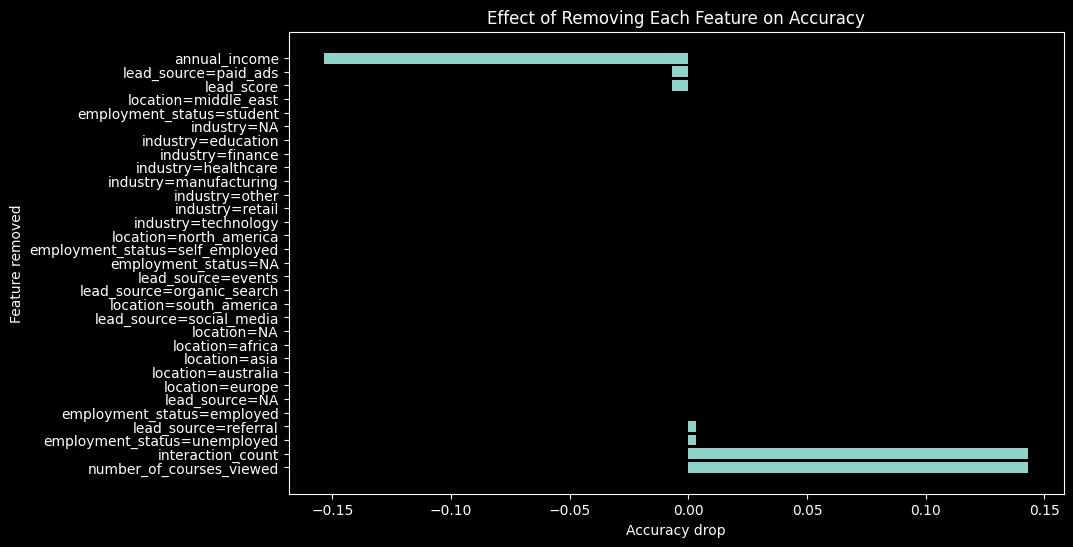

In [398]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(df_results['feature'], df_results['accuracy_drop'])
plt.xlabel("Accuracy drop")
plt.ylabel("Feature removed")
plt.title("Effect of Removing Each Feature on Accuracy")
plt.show()


In [399]:
# Useful features (from your elimination results)
useful_features = [
    'number_of_courses_viewed',
    'interaction_count',
    'employment_status=unemployed',
    'lead_source=referral',
    'lead_score',
    'annual_income'
]

# Get all feature names from DictVectorizer
feature_names = dv.get_feature_names_out()

# Boolean mask: True if feature is useful
mask = np.isin(feature_names, useful_features)

# Apply mask to select columns
X_train_reduced = X_train[:, mask]
X_val_reduced   = X_val[:, mask]
X_test_reduced  = X_test[:, mask]

print("Original features:", len(feature_names))
print("Selected features:", X_train_reduced.shape[1])


Original features: 31
Selected features: 6


In [400]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model_reduced = LogisticRegression(
    solver='liblinear', C=1.0, max_iter=1000, random_state=42
)

model_reduced.fit(X_train_reduced, y_train)

# Evaluate
y_pred_val = model_reduced.predict(X_val_reduced)
acc_val = accuracy_score(y_val, y_pred_val)

print("Validation accuracy (reduced features):", round(acc_val, 3))


Validation accuracy (reduced features): 0.706


In [401]:
print("Baseline accuracy (all features):", round(baseacc, 3))
print("Reduced-feature model accuracy:", round(acc_val, 3))
print("Improvement:", round(acc_val - baseacc, 3))


Baseline accuracy (all features): 0.7
Reduced-feature model accuracy: 0.706
Improvement: 0.007


In [402]:
import pandas as pd

coefs = model_reduced.coef_[0]
important = pd.DataFrame({
    'feature': np.array(feature_names)[mask],
    'coef': coefs,
    'abs_coef': abs(coefs)
}).sort_values(by='abs_coef', ascending=False)

print(important)


                        feature      coef  abs_coef
5      number_of_courses_viewed  0.471336  0.471336
2             interaction_count  0.286474  0.286474
1  employment_status=unemployed -0.124545  0.124545
4          lead_source=referral  0.090571  0.090571
3                    lead_score  0.053021  0.053021
0                 annual_income -0.000017  0.000017


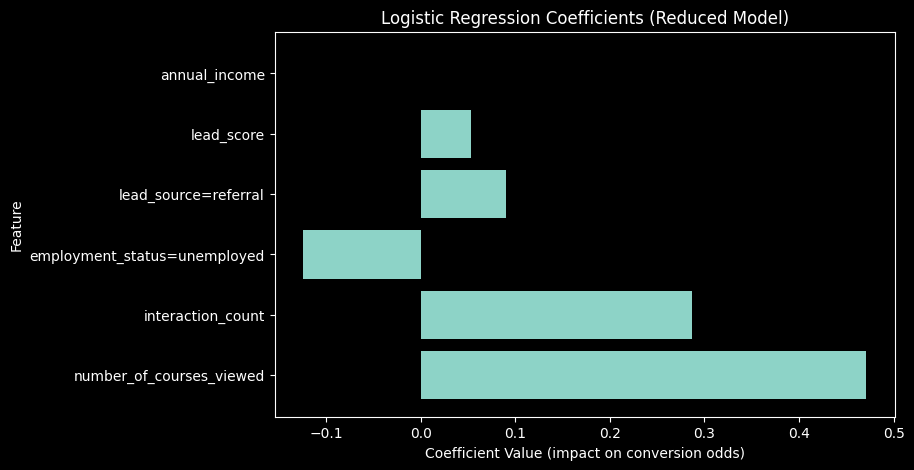

In [403]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(important['feature'], important['coef'])
plt.title("Logistic Regression Coefficients (Reduced Model)")
plt.xlabel("Coefficient Value (impact on conversion odds)")
plt.ylabel("Feature")
plt.show()


In [406]:
CVals = [0.01, 0.1, 1, 10, 100]

results = []

for CVal in CVals:
    model = LogisticRegression(solver='liblinear', C=CVal, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    
    results.append((CVal, acc))
    
results

[(0.01, 0.6996587030716723),
 (0.1, 0.6996587030716723),
 (1, 0.6996587030716723),
 (10, 0.6996587030716723),
 (100, 0.6996587030716723)]

        C  Accuracy
0    0.01       0.7
1    0.10       0.7
2    1.00       0.7
3   10.00       0.7
4  100.00       0.7

Best C value (smallest with max accuracy): 0.01


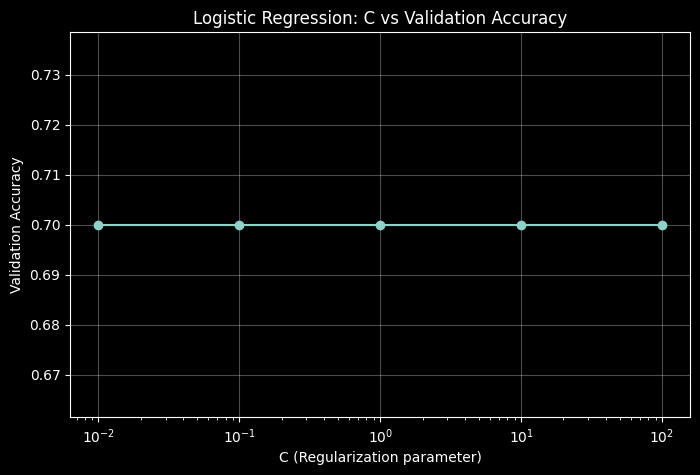

In [405]:
# Visualize the results
import matplotlib.pyplot as plt

df_c_results = pd.DataFrame(results, columns=['C', 'Accuracy'])
print(df_c_results)
print(f"\nBest C value (smallest with max accuracy): {df_c_results.loc[df_c_results['Accuracy'] == df_c_results['Accuracy'].max(), 'C'].min()}")

plt.figure(figsize=(8,5))
plt.plot(df_c_results['C'], df_c_results['Accuracy'], marker='o')
plt.xscale('log')
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Validation Accuracy')
plt.title('Logistic Regression: C vs Validation Accuracy')
plt.grid(True, alpha=0.3)
plt.show()